# PSM-XGBoost

To solve the problem of endogeneity, use propensity score matching (PSM) combined with XGBoost to analyze the Internet usage

In [1]:
%pwd

'/mnt/f/ESG09_Project/Code'

In [2]:
%cd ..

/mnt/f/ESG09_Project


/home/zhang/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import Package

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
from scipy import stats
import seaborn as sns
import shap
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from xgboost import XGBClassifier, XGBRegressor

## Load and Make Datasets

In [4]:
Df_Filename = os.path.join("Data", "GallupWB_Zhang47var798k6wave_v1.parquet")

In [5]:
Df = pd.read_parquet(Df_Filename)

In [6]:
Df.shape

(798604, 74)

In [7]:
Df.head()

,wave,INCOME_2,Cantril_ladder,Health_disable,Relative_have,Life_satisfaction,Living_standard_trend,Enough_food,Enough_shelter,Well_rested,...,Children_under15,Feeling_income,Born_here,Home_handline,Mobile_phone,Internet_access_available,Used_internet_recently,Phone_internet_access,COUNTRY_ISO3,Income_level
1709734,12,592300.098717,5.0,0.0,1.0,0.0,-1.0,1.0,0.0,0.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,USA,5.0
1709735,12,106614.017769,9.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,USA,5.0
1709736,12,21322.803554,6.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,USA,3.0
1709737,12,56860.809477,5.0,0.0,1.0,1.0,-0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,USA,5.0
1709738,12,33844.027641,7.0,1.0,1.0,1.0,-0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,USA,2.0


In [8]:
Df.columns

Index(['wave', 'INCOME_2', 'Cantril_ladder', 'Health_disable', 'Relative_have',
       'Life_satisfaction', 'Living_standard_trend', 'Enough_food',
       'Enough_shelter', 'Well_rested', 'Respected', 'Smile',
       'Interesting_thing', 'Enjoyment', 'Physical_pain', 'Worry', 'Sadness',
       'Stress', 'Anger', 'City_satisfaction', 'Recommended_live_place',
       'Economic_rating', 'Economic_trend', 'Local_job_outlook',
       'Satisfied_pubtran', 'Satisfied_road', 'Satisfied_edu',
       'Satisfied_qualityair', 'Satisfied_qualitywater',
       'Satisfied_healthcare', 'Satisfied_affhouse', 'Satisfied_oppofriend',
       'Good_minorities', 'Good_homo', 'Good_immigrants', 'Donated',
       'Volunteer', 'Help_stranger', 'Voice_official',
       'Local_police_confidence', 'Safety_walk', 'Stolen', 'Assualted',
       'Religion_importance', 'Children_respected', 'Children_learn',
       'Women_respected', 'Satisfied_dealpoor', 'Satisfied_Env_preservation',
       'Satisfied_Personalfreedom

### One-hot & Shuffle Conversion

In [9]:
print(Df['COUNTRY_ISO3'].dtype)

object


In [10]:
# 对 COUNTRY_ISO3 进行 one-hot 编码
onehot_encoder = OneHotEncoder(sparse_output=False, dtype=int)
country_encoded = onehot_encoder.fit_transform(Df[['COUNTRY_ISO3']])
country_columns = onehot_encoder.get_feature_names_out(['COUNTRY_ISO3'])

In [11]:
# 创建一个新的 DataFrame，包含 one-hot 编码后的国家列
country_df = pd.DataFrame(country_encoded, columns=country_columns, index=Df.index)

In [12]:
Df_new = pd.concat([Df.drop('COUNTRY_ISO3', axis=1), country_df], axis=1)

In [13]:
Df_new = Df_new.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
Df_new.shape

(798604, 224)

In [15]:
Df_new.head()

,wave,INCOME_2,Cantril_ladder,Health_disable,Relative_have,Life_satisfaction,Living_standard_trend,Enough_food,Enough_shelter,Well_rested,...,COUNTRY_ISO3_USA,COUNTRY_ISO3_UZB,COUNTRY_ISO3_VEN,COUNTRY_ISO3_VNM,COUNTRY_ISO3_XKX,COUNTRY_ISO3_XNC,COUNTRY_ISO3_YEM,COUNTRY_ISO3_ZAF,COUNTRY_ISO3_ZMB,COUNTRY_ISO3_ZWE
0,13,5278.624306,3.0,1.0,1.0,0.0,-0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,14,0.000000,5.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,14,5345.822529,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,17,10127.215850,5.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,16,7106.753699,6.0,0.0,0.0,0.0,-0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## PSM (XGBOOST-XGBOOST)

### 1. Data preprocessing: removing specific features

In [16]:
features_to_remove = ['Used_internet_recently', 'Phone_internet_access', 'Life_satisfaction', 'Enjoyment', 'Smile', 'Worry', 
                      'Sadness', 'Home_handline', 'Mobile_phone', "Stress", "Anger"]
Df_new = Df_new.drop(columns=features_to_remove)

### 2. Prepare data

In [17]:
X = Df_new.drop(['Internet_access_available', 'Cantril_ladder'], axis=1)
y = Df_new['Internet_access_available']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### 3. Optimization parameters

In [19]:
def optimize_xgb_params(X_train, y_train):
    param_grid = {
        'n_estimators': [1000],
        'learning_rate': [0.1],
        'max_depth': [6],
        'subsample': [0.7],
    }
    
    xgb_model = XGBClassifier(objective='binary:logistic', device = 'cuda', tree_method='hist', random_state=42)
    
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                               cv=5, scoring='roc_auc', n_jobs=1, verbose=2)
    
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best ROC AUC score:", grid_search.best_score_)
    
    return grid_search.best_estimator_

best_model = optimize_xgb_params(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/zhang/miniconda3/envs/tf/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:20:17] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.1, max_depth=6, n_estimators=1000, subsample=0.7; total time=  23.4s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=1000, subsample=0.7; total time=  22.1s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=1000, subsample=0.7; total time=  22.3s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=1000, subsample=0.7; total time=  22.3s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=1000, subsample=0.7; total time=  22.5s
Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000, 'subsample': 0.7}
Best ROC AUC score: 0.9147593860434753


### 4. Evaluate the best model

In [20]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")

Test Accuracy: 0.8442
Test ROC AUC: 0.9136


### 5. Estimating propensity scores

In [21]:
def estimate_propensity_scores(df, model):
    X = df.drop(['Internet_access_available', 'Cantril_ladder'], axis=1)
    return model.predict_proba(X)[:, 1]

Df_new['propensity_score'] = estimate_propensity_scores(Df_new, best_model)

### 6. Print propensity score statistics

In [22]:
print("\nPropensity Score Statistics:")
print(Df_new['propensity_score'].describe())

print("\nPropensity Score Statistics for Internet Access Group:")
print(Df_new[Df_new['Internet_access_available'] == 1]['propensity_score'].describe())

print("\nPropensity Score Statistics for No Internet Access Group:")
print(Df_new[Df_new['Internet_access_available'] == 0]['propensity_score'].describe())


Propensity Score Statistics:
count    798604.000000
mean          0.676030
std           0.334313
min           0.001130
25%           0.386479
50%           0.825551
75%           0.971757
max           0.999916
Name: propensity_score, dtype: float64

Propensity Score Statistics for Internet Access Group:
count    539754.000000
mean          0.847648
std           0.203108
min           0.006458
25%           0.788772
50%           0.941526
75%           0.985964
max           0.999916
Name: propensity_score, dtype: float64

Propensity Score Statistics for No Internet Access Group:
count    258850.000000
mean          0.318170
std           0.263286
min           0.001130
25%           0.095052
50%           0.238915
75%           0.498434
max           0.999601
Name: propensity_score, dtype: float64


### 6. Visualizing Propensity Score Distribution

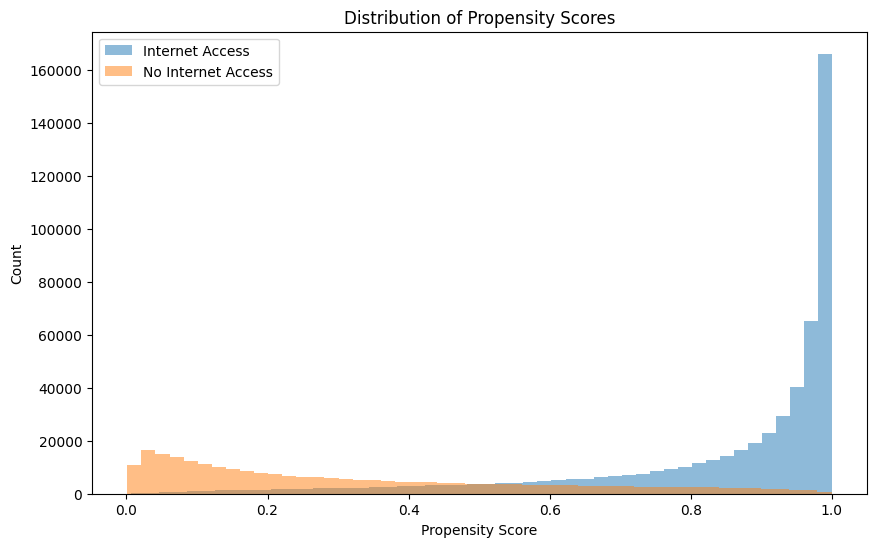

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(Df_new[Df_new['Internet_access_available'] == 1]['propensity_score'], 
         bins=50, alpha=0.5, label='Internet Access')
plt.hist(Df_new[Df_new['Internet_access_available'] == 0]['propensity_score'], 
         bins=50, alpha=0.5, label='No Internet Access')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Propensity Scores')
plt.show()

In [24]:
sd_propensity = Df_new['propensity_score'].std()
recommended_caliper = 0.2 * sd_propensity
print(f"Recommended Caliper (0.2 * SD of propensity scores): {recommended_caliper:.4f}")

Recommended Caliper (0.2 * SD of propensity scores): 0.0669


### 7. Optimized sample matching function

def match_samples_optimized(df, caliper=0.25, k=3, n_jobs=-1):
    treated = df[df['Internet_access_available'] == 1]
    control = df[df['Internet_access_available'] == 0]
    
    # 使用NearestNeighbors进行快速匹配
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean', n_jobs=n_jobs)
    nn.fit(control[['propensity_score']])
    
    distances, indices = nn.kneighbors(treated[['propensity_score']])
    
    # 向量化操作进行匹配
    valid_matches = distances.flatten() < caliper
    
    matched_treated = treated[valid_matches]
    matched_control = control.iloc[indices.flatten()[valid_matches]]
     # 合并匹配结果
    matched_df = pd.concat([matched_treated, matched_control])
    
    return matched_df

matched_df = match_samples_optimized(Df_new)

In [25]:
from sklearn.neighbors import BallTree

Total matched pairs: 233213
Unique control samples used: 84203

Distribution of control sample usage:
1     7476
2     4444
3    72283
Name: count, dtype: int64


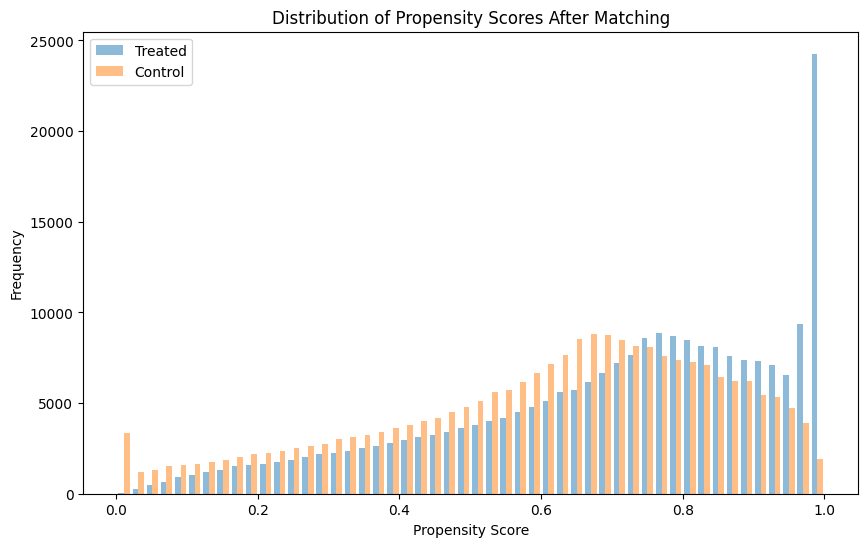

In [26]:
def match_samples_many_to_one_efficient(df, caliper=0.1, max_matches=3, n_jobs=-1, batch_size=10000):
    treated = df[df['Internet_access_available'] == 1]
    control = df[df['Internet_access_available'] == 0]
    
    # 使用BallTree进行高效的近邻搜索
    tree = BallTree(control[['propensity_score']], leaf_size=150)
    
    matched_pairs = []
    control_usage = {}

    # 批处理
    for i in range(0, len(treated), batch_size):
        batch = treated.iloc[i:i+batch_size]
        
        # 找到半径内的所有邻居
        indices = tree.query_radius(batch[['propensity_score']], r=caliper)
        
        for j, idx in enumerate(indices):
            for k in idx:
                if k not in control_usage or control_usage[k] < max_matches:
                    matched_pairs.append((i+j, k))
                    control_usage[k] = control_usage.get(k, 0) + 1
                    break  # 找到匹配后跳出内循环

    # 创建匹配后的数据框
    matched_treated = treated.iloc[[pair[0] for pair in matched_pairs]]
    matched_control = control.iloc[[pair[1] for pair in matched_pairs]]
    
    matched_df = pd.concat([matched_treated, matched_control])

    # 统计信息
    print(f"Total matched pairs: {len(matched_pairs)}")
    print(f"Unique control samples used: {len(set(pair[1] for pair in matched_pairs))}")
    
    duplicate_counts = pd.Series(control_usage).value_counts().sort_index()
    print("\nDistribution of control sample usage:")
    print(duplicate_counts)

    # 可视化匹配质量
    plt.figure(figsize=(10, 6))
    plt.hist([matched_treated['propensity_score'], matched_control['propensity_score']], 
             label=['Treated', 'Control'], bins=50, alpha=0.5)
    plt.xlabel('Propensity Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Propensity Scores After Matching')
    plt.legend()
    plt.show()

    return matched_df

# 使用函数
matched_df = match_samples_many_to_one_efficient(Df_new)

In [27]:
# 输出匹配后的样本数
print(f"\nFinal matched sample size: {len(matched_df)}")


Final matched sample size: 466426


In [28]:
matched_treated_count = len(matched_df[matched_df['Internet_access_available'] == 0])
print(f"Number of Matched Treated Samples: {matched_treated_count}")

Number of Matched Treated Samples: 233213


### 8. Balance test(Standardized Mean Differences)

In [29]:
# 平衡性检验函数
def calculate_smd(df, variables, treatment_col):
    means_treated = df[df[treatment_col] == 1][variables].mean()
    means_control = df[df[treatment_col] == 0][variables].mean()
    std_control = df[df[treatment_col] == 0][variables].std()
    smd = (means_treated - means_control) / std_control
    return smd

# 定义需要检验的变量
variables = [col for col in Df_new.columns if col not in ['propensity_score', 'Internet_access_available']]

# 计算匹配前的SMD
smd_before = calculate_smd(Df_new, variables, 'Internet_access_available')

# 计算匹配后的SMD
smd_after = calculate_smd(matched_df, variables, 'Internet_access_available')

# 将SMD结果输出为DataFrame
smd_df = pd.DataFrame({
    'Variable': variables,
    'SMD Before': smd_before.values,
    'SMD After': smd_after.values
})

print(smd_df)

             Variable  SMD Before  SMD After
0                wave    0.333406   0.049162
1            INCOME_2    0.511280   0.085271
2      Cantril_ladder    0.521002   0.136439
3      Health_disable   -0.417950  -0.063616
4       Relative_have    0.397612   0.064310
..                ...         ...        ...
207  COUNTRY_ISO3_XNC    0.095724   0.003336
208  COUNTRY_ISO3_YEM   -0.068147  -0.009328
209  COUNTRY_ISO3_ZAF   -0.009811  -0.009965
210  COUNTRY_ISO3_ZMB   -0.061810  -0.010295
211  COUNTRY_ISO3_ZWE   -0.051431  -0.010286

[212 rows x 3 columns]


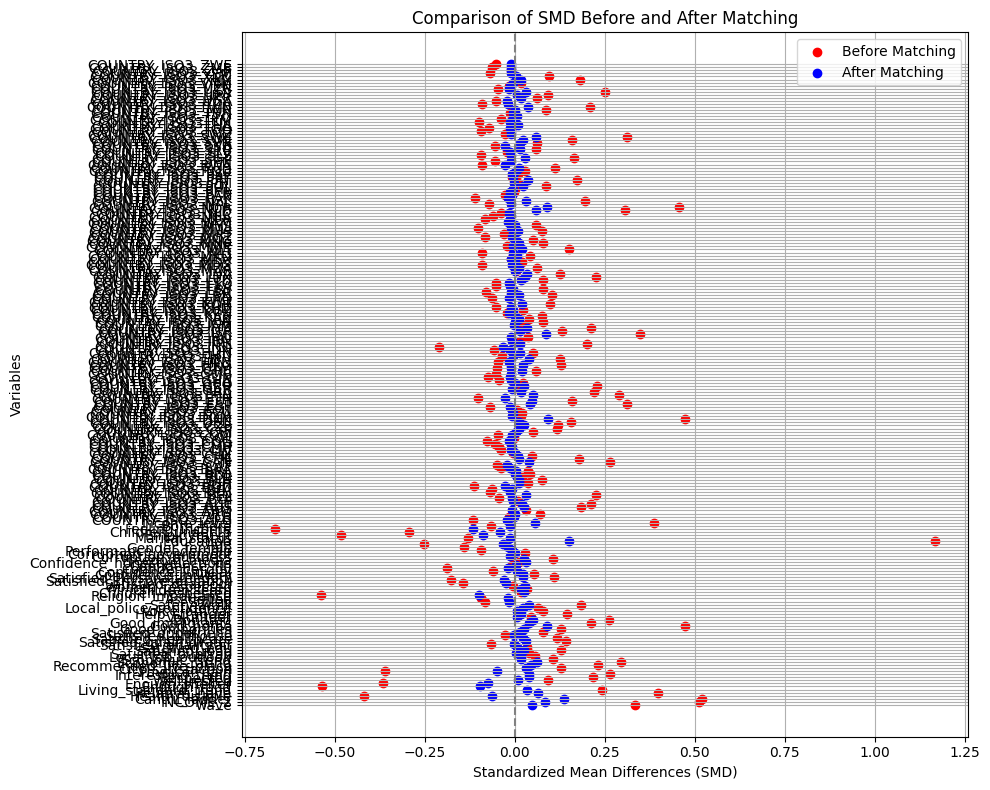

In [30]:
# 绘制匹配前后的SMD对比图
plt.figure(figsize=(10, 8))
plt.scatter(smd_df['SMD Before'], smd_df['Variable'], color='red', label='Before Matching')
plt.scatter(smd_df['SMD After'], smd_df['Variable'], color='blue', label='After Matching')
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel('Standardized Mean Differences (SMD)')
plt.ylabel('Variables')
plt.title('Comparison of SMD Before and After Matching')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 显示图表
plt.show()

### 9. Sensitivity Analysis (E-Value)

In [31]:
control = matched_df[matched_df['Internet_access_available'] == 0]['Cantril_ladder']
baseline_risk = (control < 5).mean()
print(f"Baseline risk (P(Cantril_ladder < 5 | No Internet)): {baseline_risk:.4f}")

Baseline risk (P(Cantril_ladder < 5 | No Internet)): 0.3475


Average Treatment Effect (ATE): 0.3622
95% Confidence Interval: (0.3474, 0.3769)
Risk Ratio: 2.0041
E-value: 3.4226
E-value for CI: 3.3382


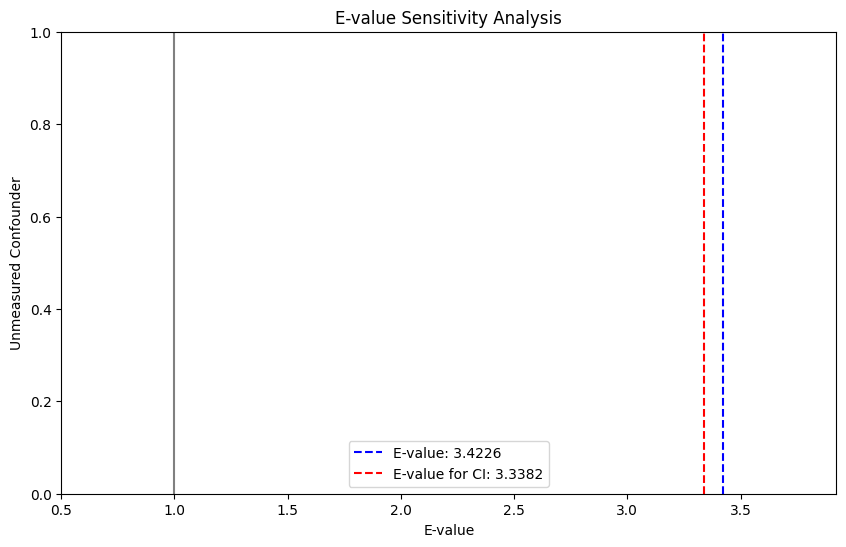

In [32]:
def calculate_evalue(effect_estimate, ci_lower, ci_upper):
    # 计算点估计的E-value
    if effect_estimate > 1:
        e_value = effect_estimate + np.sqrt(effect_estimate * (effect_estimate - 1))
    else:
        e_value = 1 / (effect_estimate + np.sqrt(effect_estimate * (effect_estimate - 1)))
    
    # 计算置信区间的E-value
    if ci_lower > 1:
        e_value_ci = ci_lower + np.sqrt(ci_lower * (ci_lower - 1))
    elif ci_upper < 1:
        e_value_ci = 1 / (ci_upper + np.sqrt(ci_upper * (ci_upper - 1)))
    else:
        e_value_ci = 1
    
    return e_value, e_value_ci

def perform_evalue_analysis(matched_df):
    treated = matched_df[matched_df['Internet_access_available'] == 1]['Cantril_ladder']
    control = matched_df[matched_df['Internet_access_available'] == 0]['Cantril_ladder']
    
    # Cantril ladder的基线风险
    baseline_risk = 0.3607
    
    # 计算平均处理效应（ATE）
    ate = treated.mean() - control.mean()
    
    # 计算标准误差
    se = np.sqrt(treated.var() / len(treated) + control.var() / len(control))
    
    # 计算95%置信区间
    df = len(treated) + len(control) - 2
    ci_lower, ci_upper = stats.t.interval(0.95, df, loc=ate, scale=se)
    
    # 计算风险比
    rr = (baseline_risk + ate) / baseline_risk
    rr_lower = (baseline_risk + ci_lower) / baseline_risk
    rr_upper = (baseline_risk + ci_upper) / baseline_risk
    
    # 计算E-value
    e_value, e_value_ci = calculate_evalue(rr, rr_lower, rr_upper)
    
    print(f"Average Treatment Effect (ATE): {ate:.4f}")
    print(f"95% Confidence Interval: ({ci_lower:.4f}, {ci_upper:.4f})")
    print(f"Risk Ratio: {rr:.4f}")
    print(f"E-value: {e_value:.4f}")
    print(f"E-value for CI: {e_value_ci:.4f}")
    
    # 可视化E-value
    plt.figure(figsize=(10, 6))
    plt.axvline(x=e_value, color='blue', linestyle='--', label=f'E-value: {e_value:.4f}')
    plt.axvline(x=e_value_ci, color='red', linestyle='--', label=f'E-value for CI: {e_value_ci:.4f}')
    plt.axvline(x=1, color='gray', linestyle='-')
    plt.xlim(0.5, max(e_value, e_value_ci) + 0.5)
    plt.ylabel('Unmeasured Confounder')
    plt.xlabel('E-value')
    plt.title('E-value Sensitivity Analysis')
    plt.legend()
    plt.show()

# 执行E-value分析
perform_evalue_analysis(matched_df)

### 10. Group analysis

In [33]:
def train_and_analyze(df, internet_access):
    subset = df[df['Internet_access_available'] == internet_access]
    X = subset.drop(['Cantril_ladder', 'Internet_access_available', 'propensity_score'], axis=1)
    y = subset['Cantril_ladder']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    model = XGBRegressor(objective='reg:squarederror', device = 'cuda', tree_method='hist', n_estimators=1000, 
                         learning_rate=0.01, max_depth=6, subsample=0.8, 
                         random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared score for {'Internet Access' if internet_access else 'No Internet Access'}: {r2:.4f}")
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    return model, shap_values, X_test

In [34]:
# Train the models separately and get the SHAP values

In [35]:
model_with_internet, shap_values_with, X_test_with = train_and_analyze(matched_df, 1)
model_without_internet, shap_values_without, X_test_without = train_and_analyze(matched_df, 0)

R-squared score for Internet Access: 0.2684
R-squared score for No Internet Access: 0.2637


### 11. SHAP value analysis

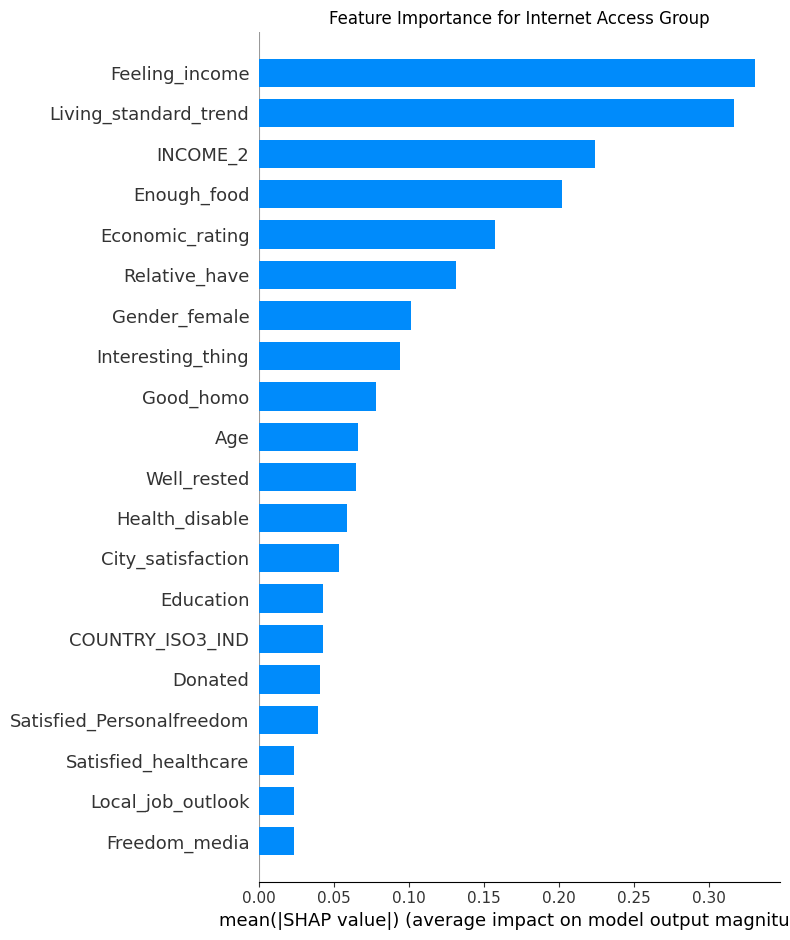

In [36]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_with, X_test_with, plot_type="bar", show=False)
plt.title("Feature Importance for Internet Access Group")
plt.tight_layout()
plt.show()

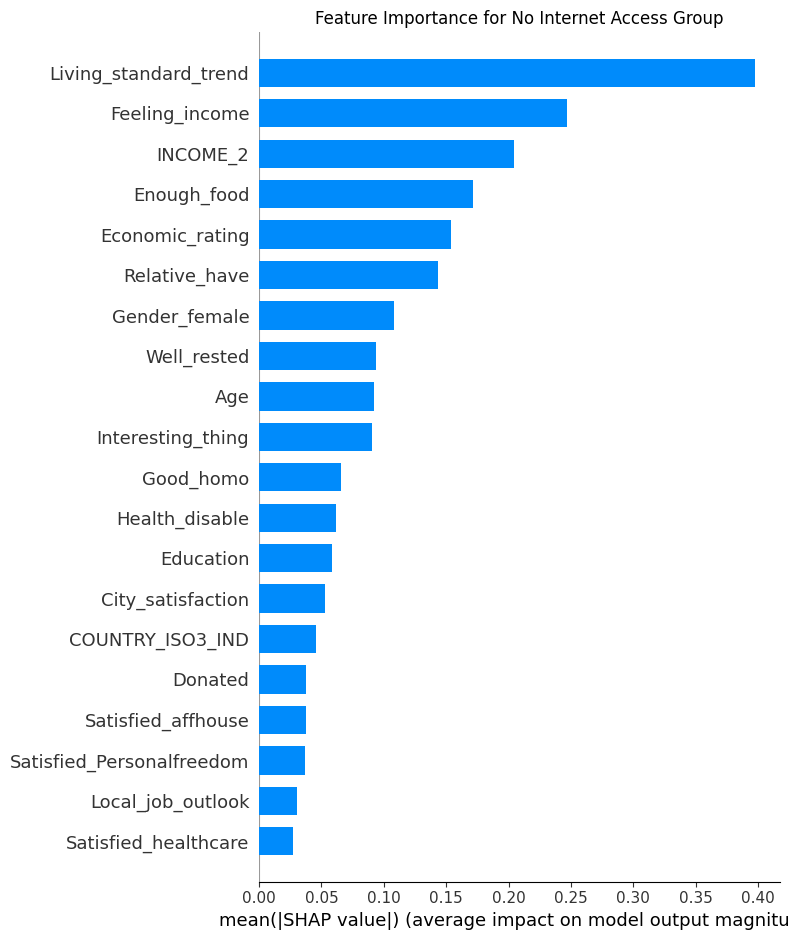

In [37]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_without, X_test_without, plot_type="bar", show=False)
plt.title("Feature Importance for No Internet Access Group")
plt.tight_layout()
plt.show()

### 12. Comparing variable effects

In [38]:
def compare_variable_impact(variable_name):
    impact_with = np.abs(shap_values_with[:, X_test_with.columns.get_loc(variable_name)]).mean()
    impact_without = np.abs(shap_values_without[:, X_test_without.columns.get_loc(variable_name)]).mean()
    
    print(f"Impact of {variable_name} on Cantril_ladder:")
    print(f"  With Internet Access: {impact_with:.4f}")
    print(f"  Without Internet Access: {impact_without:.4f}")
    print(f"  Difference: {impact_with - impact_without:.4f}")

variables_of_interest = [
    'INCOME_2', 'Education', 'Age', 'Employment', 'Health_disable', 
    'Local_job_outlook', 'Economic_rating',  # 经济前景
    'Satisfied_edu', 'Satisfied_healthcare',  # 教育和医疗满意度
    'Voice_official', 'Freedom_media',  # 公民参与和信息自由
    'Children_learn', 'Women_respected',  # 社会发展指标
    'Safety_walk', 'Confidence_judicial'  # 安全感和制度信心
]
for var in variables_of_interest:
    compare_variable_impact(var)

Impact of INCOME_2 on Cantril_ladder:
  With Internet Access: 0.2238
  Without Internet Access: 0.2041
  Difference: 0.0198
Impact of Education on Cantril_ladder:
  With Internet Access: 0.0428
  Without Internet Access: 0.0587
  Difference: -0.0159
Impact of Age on Cantril_ladder:
  With Internet Access: 0.0663
  Without Internet Access: 0.0921
  Difference: -0.0258
Impact of Employment on Cantril_ladder:
  With Internet Access: 0.0034
  Without Internet Access: 0.0055
  Difference: -0.0020
Impact of Health_disable on Cantril_ladder:
  With Internet Access: 0.0588
  Without Internet Access: 0.0619
  Difference: -0.0031
Impact of Local_job_outlook on Cantril_ladder:
  With Internet Access: 0.0235
  Without Internet Access: 0.0307
  Difference: -0.0073
Impact of Economic_rating on Cantril_ladder:
  With Internet Access: 0.1573
  Without Internet Access: 0.1537
  Difference: 0.0036
Impact of Satisfied_edu on Cantril_ladder:
  With Internet Access: 0.0136
  Without Internet Access: 0.0048

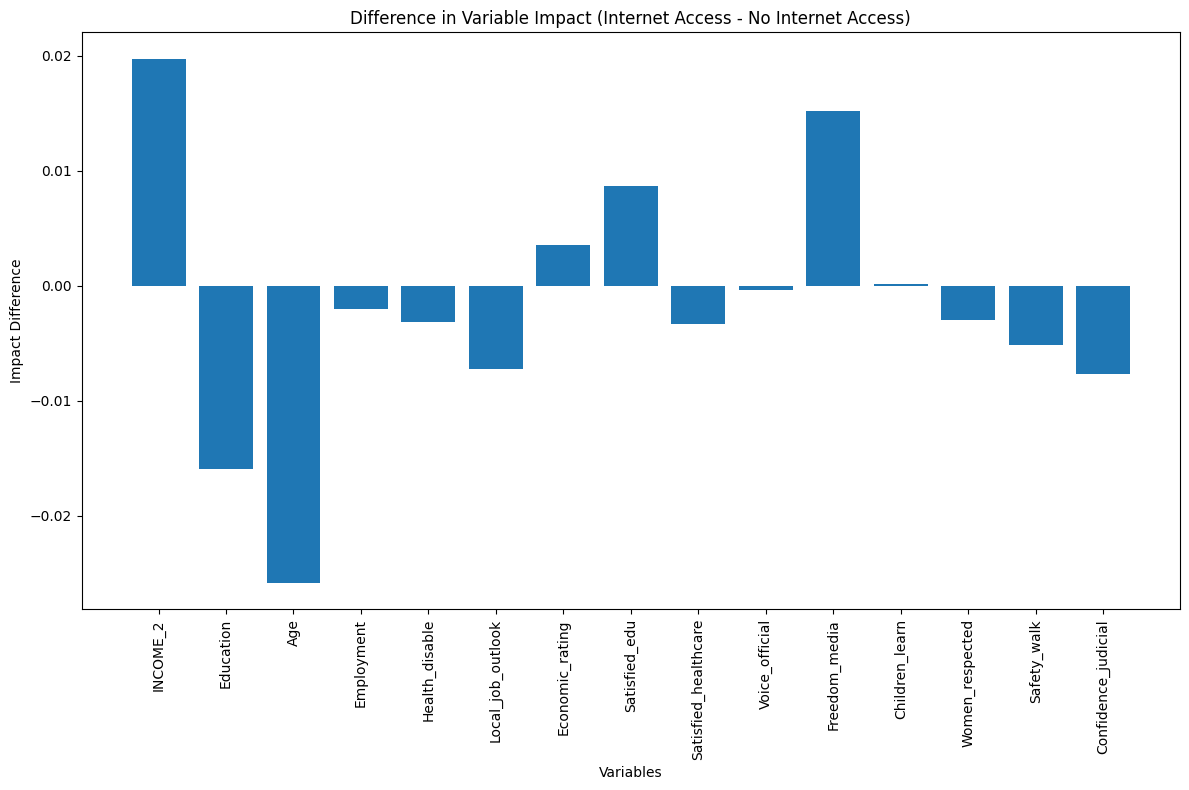

In [39]:
differences = []
for var in variables_of_interest:
    impact_with = np.abs(shap_values_with[:, X_test_with.columns.get_loc(var)]).mean()
    impact_without = np.abs(shap_values_without[:, X_test_without.columns.get_loc(var)]).mean()
    differences.append(impact_with - impact_without)

plt.figure(figsize=(12, 8))
plt.bar(variables_of_interest, differences)
plt.xticks(rotation=90)
plt.title("Difference in Variable Impact (Internet Access - No Internet Access)")
plt.xlabel("Variables")
plt.ylabel("Impact Difference")
plt.tight_layout()
plt.show()

### 13. Estimating the overall impact of Internet access

In [40]:
internet_effect = np.mean(matched_df[matched_df['Internet_access_available'] == 1]['Cantril_ladder']) - \
                  np.mean(matched_df[matched_df['Internet_access_available'] == 0]['Cantril_ladder'])
print(f"Estimated overall effect of internet access on Cantril_ladder: {internet_effect:.4f}")

Estimated overall effect of internet access on Cantril_ladder: 0.3622


### 14.Significance Test

In [41]:
!pip install statsmodels

In [42]:
from statsmodels.stats.multitest import multipletests

In [43]:
def compare_variable_impact_with_significance(variable_name):
    impact_with = np.abs(shap_values_with[:, X_test_with.columns.get_loc(variable_name)])
    impact_without = np.abs(shap_values_without[:, X_test_without.columns.get_loc(variable_name)])
    
    mean_with = impact_with.mean()
    mean_without = impact_without.mean()
    
    t_stat, p_value = stats.ttest_ind(impact_with, impact_without)
    
    print(f"Impact of {variable_name} on Cantril_ladder:")
    print(f"  With Internet Access: {mean_with:.4f}")
    print(f"  Without Internet Access: {mean_without:.4f}")
    print(f"  Difference: {mean_with - mean_without:.4f}")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    
    return variable_name, p_value

variables_of_interest = [
    'INCOME_2', 'Education', 'Age', 'Employment', 'Health_disable', 
    'Local_job_outlook', 'Economic_rating',
    'Satisfied_edu', 'Satisfied_healthcare', 'Voice_official', 'Freedom_media',
    'Children_learn', 'Women_respected', 'Safety_walk', 'Confidence_judicial'
]

# 进行所有变量的显著性测试
results = [compare_variable_impact_with_significance(var) for var in variables_of_interest]

# 使用Bonferroni校正进行多重比较调整
_, adjusted_p_values, _, _ = multipletests([r[1] for r in results], method='bonferroni')

print("\nAdjusted p-values after Bonferroni correction:")
for (var, _), adj_p in zip(results, adjusted_p_values):
    print(f"{var}: {adj_p:.4f}")

# 确定哪些差异在校正后仍然显著
significance_level = 0.05
significant_variables = [var for (var, _), adj_p in zip(results, adjusted_p_values) if adj_p < significance_level]

print("\nVariables with statistically significant differences after correction:")
for var in significant_variables:
    print(var)

Impact of INCOME_2 on Cantril_ladder:
  With Internet Access: 0.2238
  Without Internet Access: 0.2041
  Difference: 0.0198
  T-statistic: 15.4405
  P-value: 0.0000
Impact of Education on Cantril_ladder:
  With Internet Access: 0.0428
  Without Internet Access: 0.0587
  Difference: -0.0159
  T-statistic: -39.8960
  P-value: 0.0000
Impact of Age on Cantril_ladder:
  With Internet Access: 0.0663
  Without Internet Access: 0.0921
  Difference: -0.0258
  T-statistic: -41.6937
  P-value: 0.0000
Impact of Employment on Cantril_ladder:
  With Internet Access: 0.0034
  Without Internet Access: 0.0055
  Difference: -0.0020
  T-statistic: -31.3326
  P-value: 0.0000
Impact of Health_disable on Cantril_ladder:
  With Internet Access: 0.0588
  Without Internet Access: 0.0619
  Difference: -0.0031
  T-statistic: -8.5996
  P-value: 0.0000
Impact of Local_job_outlook on Cantril_ladder:
  With Internet Access: 0.0235
  Without Internet Access: 0.0307
  Difference: -0.0073
  T-statistic: -45.8895
  P-va

## PSM (Random Forest-XGBOOST)

In [16]:
features_to_remove = ['Used_internet_recently', 'Phone_internet_access', 'Life_satisfaction', 'Enjoyment', 'Smile', 'Worry', 'Sadness']
Df_new = Df_new.drop(columns=features_to_remove)

In [17]:
# 2. 准备数据
X = Df_new.drop(['Internet_access_available', 'Cantril_ladder'], axis=1)
y = Df_new['Internet_access_available']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [19]:
# 3. 优化随机森林参数
def optimize_rf_params(X_train, y_train):
    param_grid = {
        'n_estimators': [500],
        'max_depth': [10],
    
    }
    
    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                               cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)
    
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best ROC AUC score:", grid_search.best_score_)
    
    return grid_search.best_estimator_

best_model = optimize_rf_params(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 10, 'n_estimators': 500}
Best ROC AUC score: 0.8999067284517722


In [20]:
# 4. 评估最佳模型
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")

Test Accuracy: 0.8271
Test ROC AUC: 0.8993


In [21]:
# 5. 估算倾向得分
def estimate_propensity_scores(df, model):
    X = df.drop(['Internet_access_available', 'Cantril_ladder'], axis=1)
    return model.predict_proba(X)[:, 1]

Df_new['propensity_score'] = estimate_propensity_scores(Df_new, best_model)

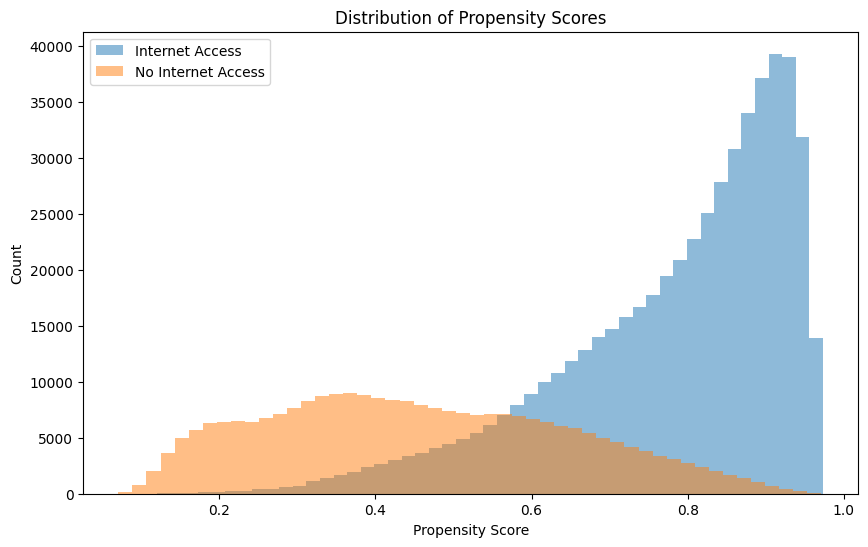

In [22]:
# 6. 可视化倾向得分分布
plt.figure(figsize=(10, 6))
plt.hist(Df_new[Df_new['Internet_access_available'] == 1]['propensity_score'], 
         bins=50, alpha=0.5, label='Internet Access')
plt.hist(Df_new[Df_new['Internet_access_available'] == 0]['propensity_score'], 
         bins=50, alpha=0.5, label='No Internet Access')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Propensity Scores')
plt.show()


In [32]:
sd_propensity = Df_new['propensity_score'].std()
recommended_caliper = 0.2 * sd_propensity
print(f"Recommended Caliper (0.2 * SD of propensity scores): {recommended_caliper:.4f}")

Recommended Caliper (0.2 * SD of propensity scores): 0.0447


In [26]:
from sklearn.neighbors import BallTree

Total matched pairs: 323427
Unique control samples used: 114906

Distribution of control sample usage:
1      8010
2      5271
3    101625
Name: count, dtype: int64


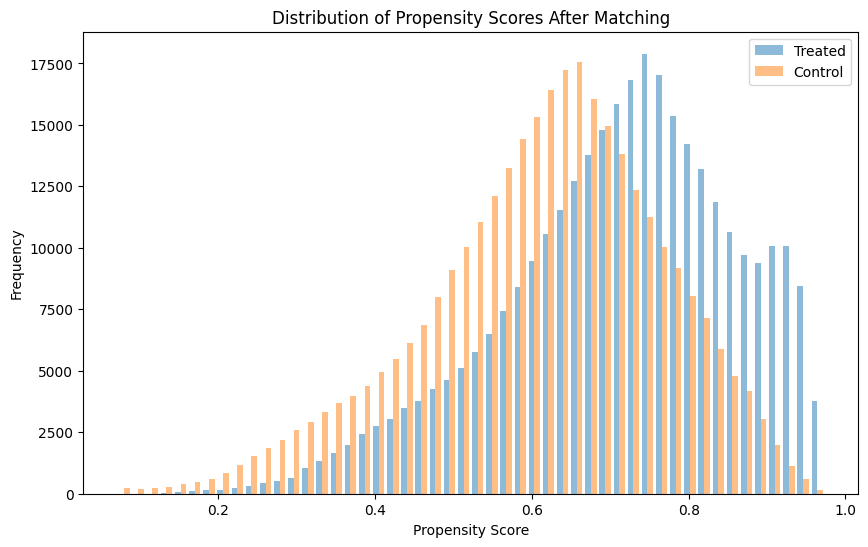

In [39]:
# 7. 多对一匹配
def match_samples_many_to_one_efficient(df, caliper=0.1, max_matches=3, n_jobs=-1, batch_size=12000):
    treated = df[df['Internet_access_available'] == 1]
    control = df[df['Internet_access_available'] == 0]
    
    tree = BallTree(control[['propensity_score']], leaf_size=150)
    
    matched_pairs = []
    control_usage = {}

    for i in range(0, len(treated), batch_size):
        batch = treated.iloc[i:i+batch_size]
        indices = tree.query_radius(batch[['propensity_score']], r=caliper)
        
        for j, idx in enumerate(indices):
            for k in idx:
                if k not in control_usage or control_usage[k] < max_matches:
                    matched_pairs.append((i+j, k))
                    control_usage[k] = control_usage.get(k, 0) + 1
                    break

    matched_treated = treated.iloc[[pair[0] for pair in matched_pairs]]
    matched_control = control.iloc[[pair[1] for pair in matched_pairs]]
    
    matched_df = pd.concat([matched_treated, matched_control])

    print(f"Total matched pairs: {len(matched_pairs)}")
    print(f"Unique control samples used: {len(set(pair[1] for pair in matched_pairs))}")
    
    duplicate_counts = pd.Series(control_usage).value_counts().sort_index()
    print("\nDistribution of control sample usage:")
    print(duplicate_counts)

    plt.figure(figsize=(10, 6))
    plt.hist([matched_treated['propensity_score'], matched_control['propensity_score']], 
             label=['Treated', 'Control'], bins=50, alpha=0.5)
    plt.xlabel('Propensity Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Propensity Scores After Matching')
    plt.legend()
    plt.show()

    return matched_df

matched_df = match_samples_many_to_one_efficient(Df_new)

             Variable  SMD Before  SMD After
0                wave    0.333406   0.219404
1            INCOME_2    0.511280   0.116867
2      Cantril_ladder    0.521002   0.192962
3      Health_disable   -0.417950  -0.117964
4       Relative_have    0.397612   0.095405
..                ...         ...        ...
211  COUNTRY_ISO3_XNC    0.095724   0.019784
212  COUNTRY_ISO3_YEM   -0.068147  -0.034988
213  COUNTRY_ISO3_ZAF   -0.009811  -0.024331
214  COUNTRY_ISO3_ZMB   -0.061810  -0.034642
215  COUNTRY_ISO3_ZWE   -0.051431  -0.038074

[216 rows x 3 columns]


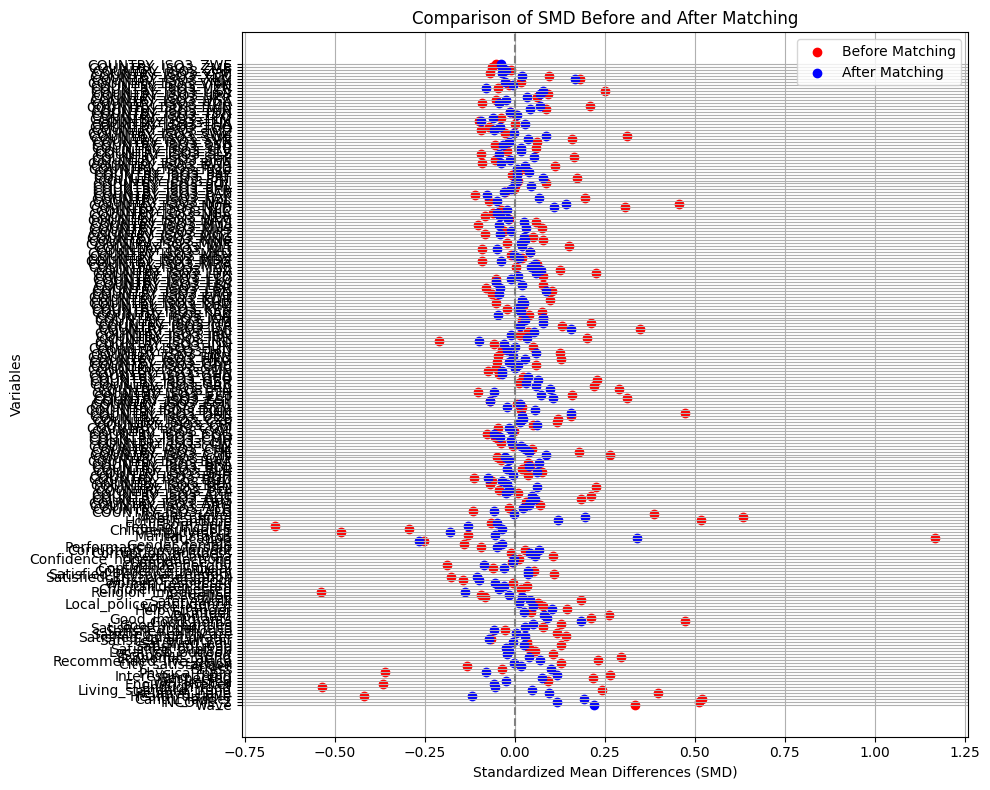

In [40]:
# 8. 平衡性检验
def calculate_smd(df, variables, treatment_col):
    means_treated = df[df[treatment_col] == 1][variables].mean()
    means_control = df[df[treatment_col] == 0][variables].mean()
    std_control = df[df[treatment_col] == 0][variables].std()
    smd = (means_treated - means_control) / std_control
    return smd

variables = [col for col in Df_new.columns if col not in ['propensity_score', 'Internet_access_available']]

smd_before = calculate_smd(Df_new, variables, 'Internet_access_available')
smd_after = calculate_smd(matched_df, variables, 'Internet_access_available')

smd_df = pd.DataFrame({
    'Variable': variables,
    'SMD Before': smd_before.values,
    'SMD After': smd_after.values
})
print(smd_df)

plt.figure(figsize=(10, 8))
plt.scatter(smd_df['SMD Before'], smd_df['Variable'], color='red', label='Before Matching')
plt.scatter(smd_df['SMD After'], smd_df['Variable'], color='blue', label='After Matching')
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel('Standardized Mean Differences (SMD)')
plt.ylabel('Variables')
plt.title('Comparison of SMD Before and After Matching')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
# 9. 分组分析
def train_and_analyze(df, internet_access):
    subset = df[df['Internet_access_available'] == internet_access]
    X = subset.drop(['Cantril_ladder', 'Internet_access_available', 'propensity_score'], axis=1)
    y = subset['Cantril_ladder']

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    model = XGBRegressor(objective='reg:squarederror', device='cuda', tree_method='hist', n_estimators=1000, 
                         learning_rate=0.01, max_depth=6, subsample=0.8, 
                         random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared score for {'Internet Access' if internet_access else 'No Internet Access'}: {r2:.4f}")
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    return model, shap_values, X_test

model_with_internet, shap_values_with, X_test_with = train_and_analyze(matched_df, 1)
model_without_internet, shap_values_without, X_test_without = train_and_analyze(matched_df, 0)

R-squared score for Internet Access: 0.2771
R-squared score for No Internet Access: 0.2578


In [ ]:
# 10. SHAP值分析
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_with, X_test_with, plot_type="bar", show=False)
plt.title("Feature Importance for Internet Access Group")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_without, X_test_without, plot_type="bar", show=False)
plt.title("Feature Importance for No Internet Access Group")
plt.tight_layout()
plt.show()
